"Deep learning and Reinforcement Learning" final project, by vectorkoz, June 2024

[Project source](https://github.com/vectorkoz/spaceship-titanic.git)

# Project goals

1. Enter a popular Kaggle competition.
2. Use Keras to construct various types of artificial neural networks for the competition.
3. Use K-fold cross-validation and optuna to find the best hyperparameters for the models.
4. Sumbit results to Kaggle and see how well different artificial neural network types did.

# Data Summary

In this project, models for the popular ["Spaceship Titanic"](https://www.kaggle.com/competitions/spaceship-titanic/overview) Kaggle competition are constructed. The dataset from the competition is similar to the popular Titanic data set. According to the authors of the dataset,
```
The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.
```
```
While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!
```
```
To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.
```

The train set contains 8693 entries, the test set - 4277 entries. Descriptions of the columns are provided below.

1. `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
2. `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
3. `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
4. `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
5. `Destination` - The planet the passenger will be debarking to.
6. `Age` - The age of the passenger.
7. `VIP` - Whether the passenger has paid for special VIP service during the voyage.
8. `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
9. `Name` - The first and last names of the passenger.
10. `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# Data preparation

Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from scipy.stats import boxcox

from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score

import optuna

Importing the data and splitting the `Cabin` column into 3 separate columns, as is advised for this dataset. Also, adding a separate column showing whether the original `Cabin` column had a NULL value, and deleting the old `Cabin` column, as well as the `Name` column, which won't be used in this project.

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df[["Deck", "Cabin_num", "Side"]] = train_df["Cabin"].str.split("/", expand=True)
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
try:
    train_df["Cabin_unknown"]=train_df.Cabin.isnull().astype(float)
    train_df["Transported"] = train_df["Transported"].astype(float)
    test_df["Cabin_unknown"]=test_df.Cabin.isnull().astype(float)
    train_df.drop(columns=['Cabin','Name','PassengerId'], inplace=True)
    test_df.drop(columns=['Cabin','Name'], inplace=True)
except KeyError:
    print("Field does not exist")

Looking at the datasets' information.

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8492 non-null   object 
 1   CryoSleep      8476 non-null   object 
 2   Destination    8511 non-null   object 
 3   Age            8514 non-null   float64
 4   VIP            8490 non-null   object 
 5   RoomService    8512 non-null   float64
 6   FoodCourt      8510 non-null   float64
 7   ShoppingMall   8485 non-null   float64
 8   Spa            8510 non-null   float64
 9   VRDeck         8505 non-null   float64
 10  Transported    8693 non-null   float64
 11  Deck           8494 non-null   object 
 12  Cabin_num      8494 non-null   object 
 13  Side           8494 non-null   object 
 14  Cabin_unknown  8693 non-null   float64
dtypes: float64(8), object(7)
memory usage: 1018.8+ KB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    4277 non-null   object 
 1   HomePlanet     4190 non-null   object 
 2   CryoSleep      4184 non-null   object 
 3   Destination    4185 non-null   object 
 4   Age            4186 non-null   float64
 5   VIP            4184 non-null   object 
 6   RoomService    4195 non-null   float64
 7   FoodCourt      4171 non-null   float64
 8   ShoppingMall   4179 non-null   float64
 9   Spa            4176 non-null   float64
 10  VRDeck         4197 non-null   float64
 11  Deck           4177 non-null   object 
 12  Cabin_num      4177 non-null   object 
 13  Side           4177 non-null   object 
 14  Cabin_unknown  4277 non-null   float64
dtypes: float64(7), object(8)
memory usage: 501.3+ KB


Most columns in the data have NULL values that need to be filled.

## Filling NULL values

#### Cabin_num

Filling the missing `Cabin_num` values with 0 and transforming the column to float.

In [5]:
train_df.loc[train_df.Cabin_unknown==1,['Cabin_num']]='0'
test_df.loc[test_df.Cabin_unknown==1,['Cabin_num']]='0'

train_df["Cabin_num"] = train_df["Cabin_num"].astype(float)
test_df["Cabin_num"] = test_df["Cabin_num"].astype(float)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8492 non-null   object 
 1   CryoSleep      8476 non-null   object 
 2   Destination    8511 non-null   object 
 3   Age            8514 non-null   float64
 4   VIP            8490 non-null   object 
 5   RoomService    8512 non-null   float64
 6   FoodCourt      8510 non-null   float64
 7   ShoppingMall   8485 non-null   float64
 8   Spa            8510 non-null   float64
 9   VRDeck         8505 non-null   float64
 10  Transported    8693 non-null   float64
 11  Deck           8494 non-null   object 
 12  Cabin_num      8693 non-null   float64
 13  Side           8494 non-null   object 
 14  Cabin_unknown  8693 non-null   float64
dtypes: float64(9), object(6)
memory usage: 1018.8+ KB


Here's how the distribution of `Cabin_num` values looks now.

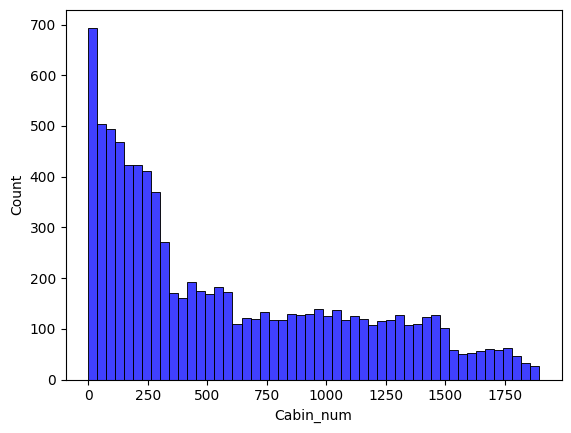

In [7]:
sns.histplot(train_df['Cabin_num'], color='b', bins=50);

#### Age

Adding a separate column to show where the age values are missing.

In [8]:
train_df["Age_unknown"]=train_df.Age.isnull().astype(float)
test_df["Age_unknown"]=test_df.Age.isnull().astype(float)

In the train set, age is missing in very few entries, but maybe this column will help somehow.

In [9]:
train_df["Age_unknown"].value_counts()

Age_unknown
0.0    8514
1.0     179
Name: count, dtype: int64

Replacing the NULL age values with the median value of age: 27  years.

In [10]:
median_age=train_df[train_df.Age_unknown==0].Age.astype(int).median()
median_age

27.0

In [11]:
train_df.loc[train_df.Age_unknown==1,['Age']]=median_age
test_df.loc[test_df.Age_unknown==1,['Age']]=median_age

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8492 non-null   object 
 1   CryoSleep      8476 non-null   object 
 2   Destination    8511 non-null   object 
 3   Age            8693 non-null   float64
 4   VIP            8490 non-null   object 
 5   RoomService    8512 non-null   float64
 6   FoodCourt      8510 non-null   float64
 7   ShoppingMall   8485 non-null   float64
 8   Spa            8510 non-null   float64
 9   VRDeck         8505 non-null   float64
 10  Transported    8693 non-null   float64
 11  Deck           8494 non-null   object 
 12  Cabin_num      8693 non-null   float64
 13  Side           8494 non-null   object 
 14  Cabin_unknown  8693 non-null   float64
 15  Age_unknown    8693 non-null   float64
dtypes: float64(10), object(6)
memory usage: 1.1+ MB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    4277 non-null   object 
 1   HomePlanet     4190 non-null   object 
 2   CryoSleep      4184 non-null   object 
 3   Destination    4185 non-null   object 
 4   Age            4277 non-null   float64
 5   VIP            4184 non-null   object 
 6   RoomService    4195 non-null   float64
 7   FoodCourt      4171 non-null   float64
 8   ShoppingMall   4179 non-null   float64
 9   Spa            4176 non-null   float64
 10  VRDeck         4197 non-null   float64
 11  Deck           4177 non-null   object 
 12  Cabin_num      4277 non-null   float64
 13  Side           4177 non-null   object 
 14  Cabin_unknown  4277 non-null   float64
 15  Age_unknown    4277 non-null   float64
dtypes: float64(9), object(7)
memory usage: 534.8+ KB


Here's how the distribution of `Age` values looks now.

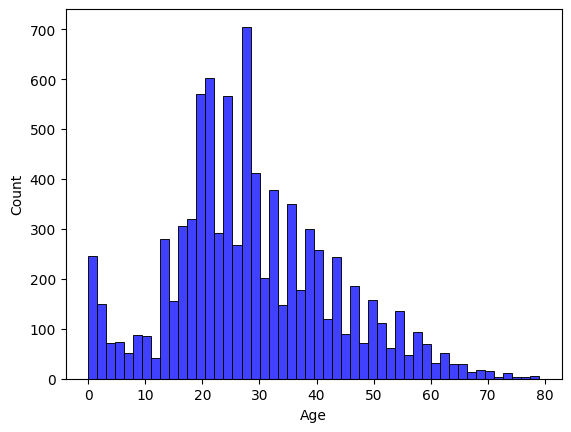

In [14]:
sns.histplot(train_df['Age'], color='b', bins=50);

#### Categorical columns

Convert all the categorical features to strings and replace the NULL values with the string 'Unknown'

In [15]:
categ_features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
for col in categ_features:
    train_df.loc[train_df[col].isnull(),[col]]='Unknown'
    train_df[col]=train_df[col].astype("string")
    test_df.loc[test_df[col].isnull(),[col]]='Unknown'
    test_df[col]=test_df[col].astype("string")

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   string 
 1   CryoSleep      8693 non-null   string 
 2   Destination    8693 non-null   string 
 3   Age            8693 non-null   float64
 4   VIP            8693 non-null   string 
 5   RoomService    8512 non-null   float64
 6   FoodCourt      8510 non-null   float64
 7   ShoppingMall   8485 non-null   float64
 8   Spa            8510 non-null   float64
 9   VRDeck         8505 non-null   float64
 10  Transported    8693 non-null   float64
 11  Deck           8693 non-null   string 
 12  Cabin_num      8693 non-null   float64
 13  Side           8693 non-null   string 
 14  Cabin_unknown  8693 non-null   float64
 15  Age_unknown    8693 non-null   float64
dtypes: float64(10), string(6)
memory usage: 1.1 MB


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    4277 non-null   object 
 1   HomePlanet     4277 non-null   string 
 2   CryoSleep      4277 non-null   string 
 3   Destination    4277 non-null   string 
 4   Age            4277 non-null   float64
 5   VIP            4277 non-null   string 
 6   RoomService    4195 non-null   float64
 7   FoodCourt      4171 non-null   float64
 8   ShoppingMall   4179 non-null   float64
 9   Spa            4176 non-null   float64
 10  VRDeck         4197 non-null   float64
 11  Deck           4277 non-null   string 
 12  Cabin_num      4277 non-null   float64
 13  Side           4277 non-null   string 
 14  Cabin_unknown  4277 non-null   float64
 15  Age_unknown    4277 non-null   float64
dtypes: float64(9), object(1), string(6)
memory usage: 534.8+ KB


#### Other numerical columns

Looking at the distributions of all the other numerical columns.

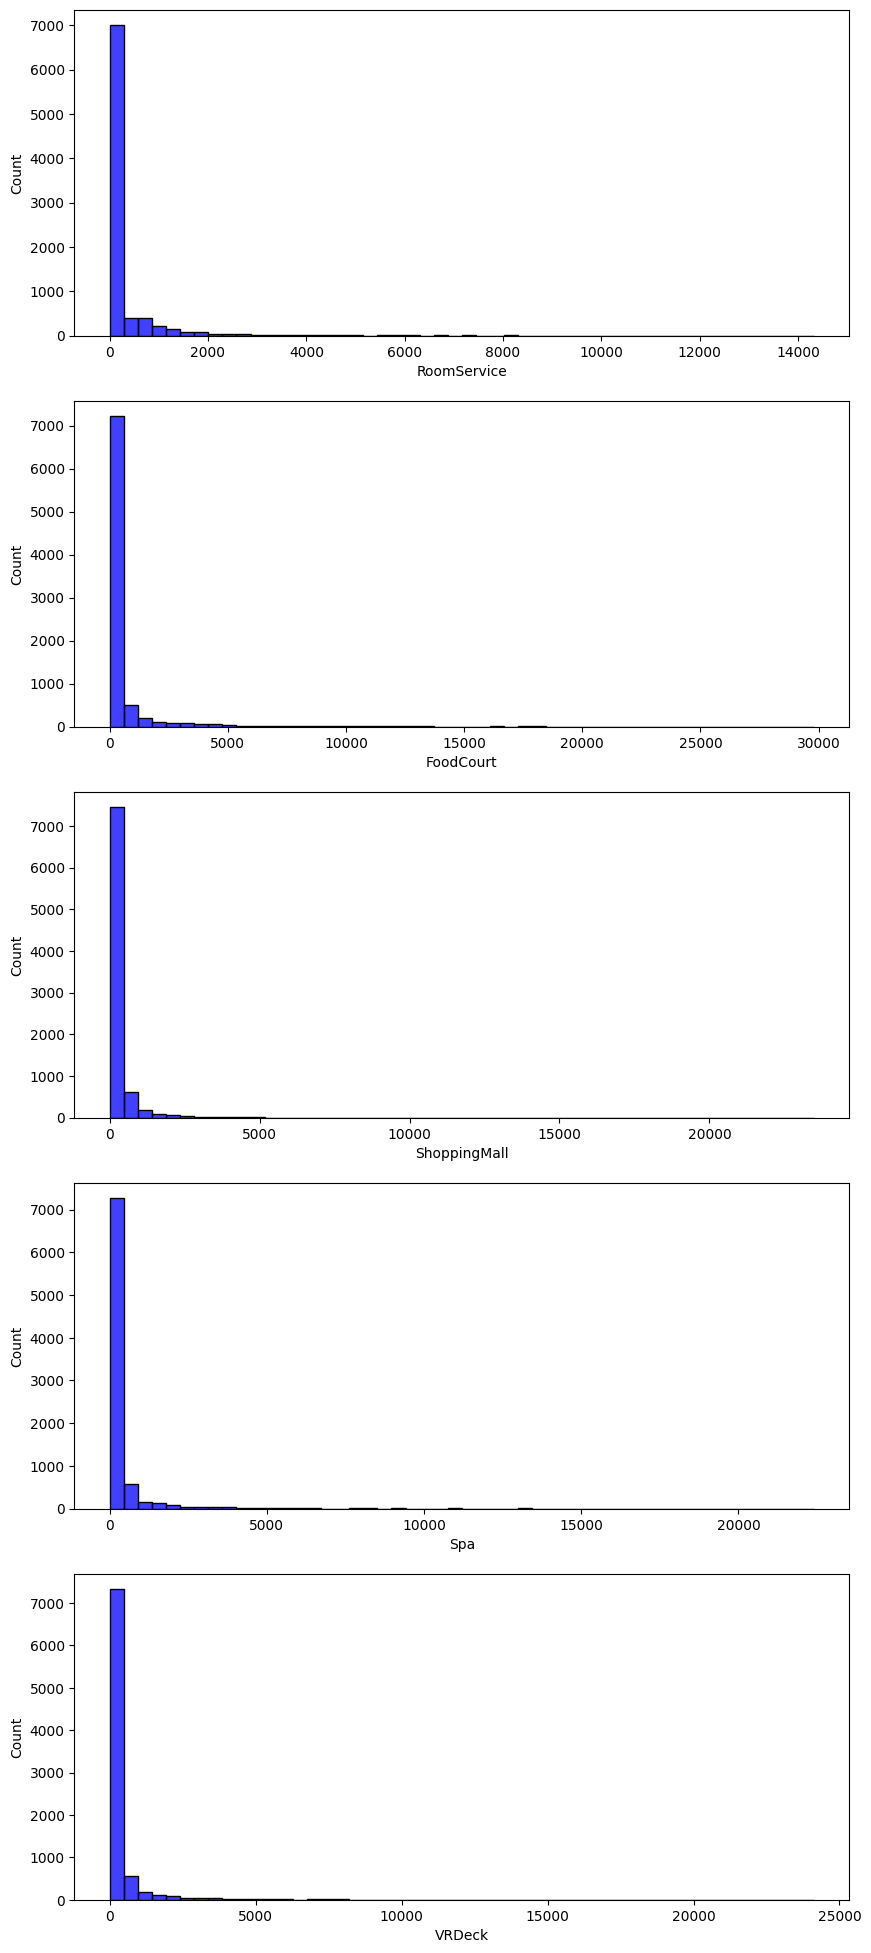

In [18]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(train_df['RoomService'], color='b', bins=50, ax=ax[0]);
sns.histplot(train_df['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(train_df['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(train_df['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(train_df['VRDeck'], color='b', bins=50, ax=ax[4]);

In these columns, relatively few values are missing and most of the existing ones are 0. It's reasonable to just replace the NULL values with 0 without adding more columns.

In [19]:
train_df.fillna(value=0, inplace=True)
test_df.fillna(value=0, inplace=True)

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   string 
 1   CryoSleep      8693 non-null   string 
 2   Destination    8693 non-null   string 
 3   Age            8693 non-null   float64
 4   VIP            8693 non-null   string 
 5   RoomService    8693 non-null   float64
 6   FoodCourt      8693 non-null   float64
 7   ShoppingMall   8693 non-null   float64
 8   Spa            8693 non-null   float64
 9   VRDeck         8693 non-null   float64
 10  Transported    8693 non-null   float64
 11  Deck           8693 non-null   string 
 12  Cabin_num      8693 non-null   float64
 13  Side           8693 non-null   string 
 14  Cabin_unknown  8693 non-null   float64
 15  Age_unknown    8693 non-null   float64
dtypes: float64(10), string(6)
memory usage: 1.1 MB


In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    4277 non-null   object 
 1   HomePlanet     4277 non-null   string 
 2   CryoSleep      4277 non-null   string 
 3   Destination    4277 non-null   string 
 4   Age            4277 non-null   float64
 5   VIP            4277 non-null   string 
 6   RoomService    4277 non-null   float64
 7   FoodCourt      4277 non-null   float64
 8   ShoppingMall   4277 non-null   float64
 9   Spa            4277 non-null   float64
 10  VRDeck         4277 non-null   float64
 11  Deck           4277 non-null   string 
 12  Cabin_num      4277 non-null   float64
 13  Side           4277 non-null   string 
 14  Cabin_unknown  4277 non-null   float64
 15  Age_unknown    4277 non-null   float64
dtypes: float64(9), object(1), string(6)
memory usage: 534.8+ KB


Now, all the NULL values are finally filled. Next, categorical features need to be one-hot encoded.

## OHC

Here, categorical features are one-hot encoded fully, i.e. without dropping any categories. Then, the one-hot encoded columns are added to the dataset and the old categorical columns are dropped.

In [22]:
OHC=OneHotEncoder(sparse_output=False)

OHC_train=OHC.fit_transform(train_df[categ_features])
OHC_test=OHC.transform(test_df[categ_features])

OHC_train=pd.DataFrame(OHC_train, index=train_df.index, columns=OHC.get_feature_names_out())
OHC_test=pd.DataFrame(OHC_test, index=test_df.index, columns=OHC.get_feature_names_out())

train_df=pd.concat([train_df, OHC_train], axis=1)
test_df=pd.concat([test_df, OHC_test], axis=1)

train_df.drop(columns=categ_features, inplace=True)
test_df.drop(columns=categ_features, inplace=True)

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   Transported                8693 non-null   float64
 7   Cabin_num                  8693 non-null   float64
 8   Cabin_unknown              8693 non-null   float64
 9   Age_unknown                8693 non-null   float64
 10  HomePlanet_Earth           8693 non-null   float64
 11  HomePlanet_Europa          8693 non-null   float64
 12  HomePlanet_Mars            8693 non-null   float64
 13  HomePlanet_Unknown         8693 non-null   float

In [24]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                4277 non-null   object 
 1   Age                        4277 non-null   float64
 2   RoomService                4277 non-null   float64
 3   FoodCourt                  4277 non-null   float64
 4   ShoppingMall               4277 non-null   float64
 5   Spa                        4277 non-null   float64
 6   VRDeck                     4277 non-null   float64
 7   Cabin_num                  4277 non-null   float64
 8   Cabin_unknown              4277 non-null   float64
 9   Age_unknown                4277 non-null   float64
 10  HomePlanet_Earth           4277 non-null   float64
 11  HomePlanet_Europa          4277 non-null   float64
 12  HomePlanet_Mars            4277 non-null   float64
 13  HomePlanet_Unknown         4277 non-null   float

## Transformations

For artificial neural network models, it could be beneficial to transform the input data so that its distribution is more normal.  Looking at he skew of all numerical columns, it's clear that some are heavily skewed.

In [25]:
continious_cols=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num']
skew=train_df[continious_cols].skew().sort_values(ascending=False)
skew

ShoppingMall    12.763842
VRDeck           7.904554
Spa              7.716450
FoodCourt        7.177515
RoomService      6.397766
Cabin_num        0.737448
Age              0.431102
dtype: float64

Setting a common skew threshold of 0.75.  

In [26]:
cols_to_unskew=skew[skew>0.75].index.tolist()
cols_to_unskew

['ShoppingMall', 'VRDeck', 'Spa', 'FoodCourt', 'RoomService']

Here, transformations will be done using the Box-Cox method. For this method, all input values need to be positive.

In [27]:
train_df[cols_to_unskew].min()

ShoppingMall    0.0
VRDeck          0.0
Spa             0.0
FoodCourt       0.0
RoomService     0.0
dtype: float64

Adding a small number to the values so that hey are all positive, then transforming them. 

In [28]:
epsilon=0.01
for col in cols_to_unskew:
    train_df[col]=train_df[col] + epsilon
    test_df[col]=test_df[col] + epsilon

In [29]:
for col in cols_to_unskew:
    newcol, lmax_mle = boxcox(train_df[col])
    train_df[col] = newcol
    newcol = boxcox(test_df[col], lmbda=lmax_mle)
    test_df[col] = newcol

Now all the skews are below the 0.75 threshold and the distributions look more normal.

In [30]:
train_df[continious_cols].skew().sort_values(ascending=False)

ShoppingMall    0.740733
Cabin_num       0.737448
RoomService     0.720910
VRDeck          0.686919
FoodCourt       0.667141
Spa             0.606437
Age             0.431102
dtype: float64

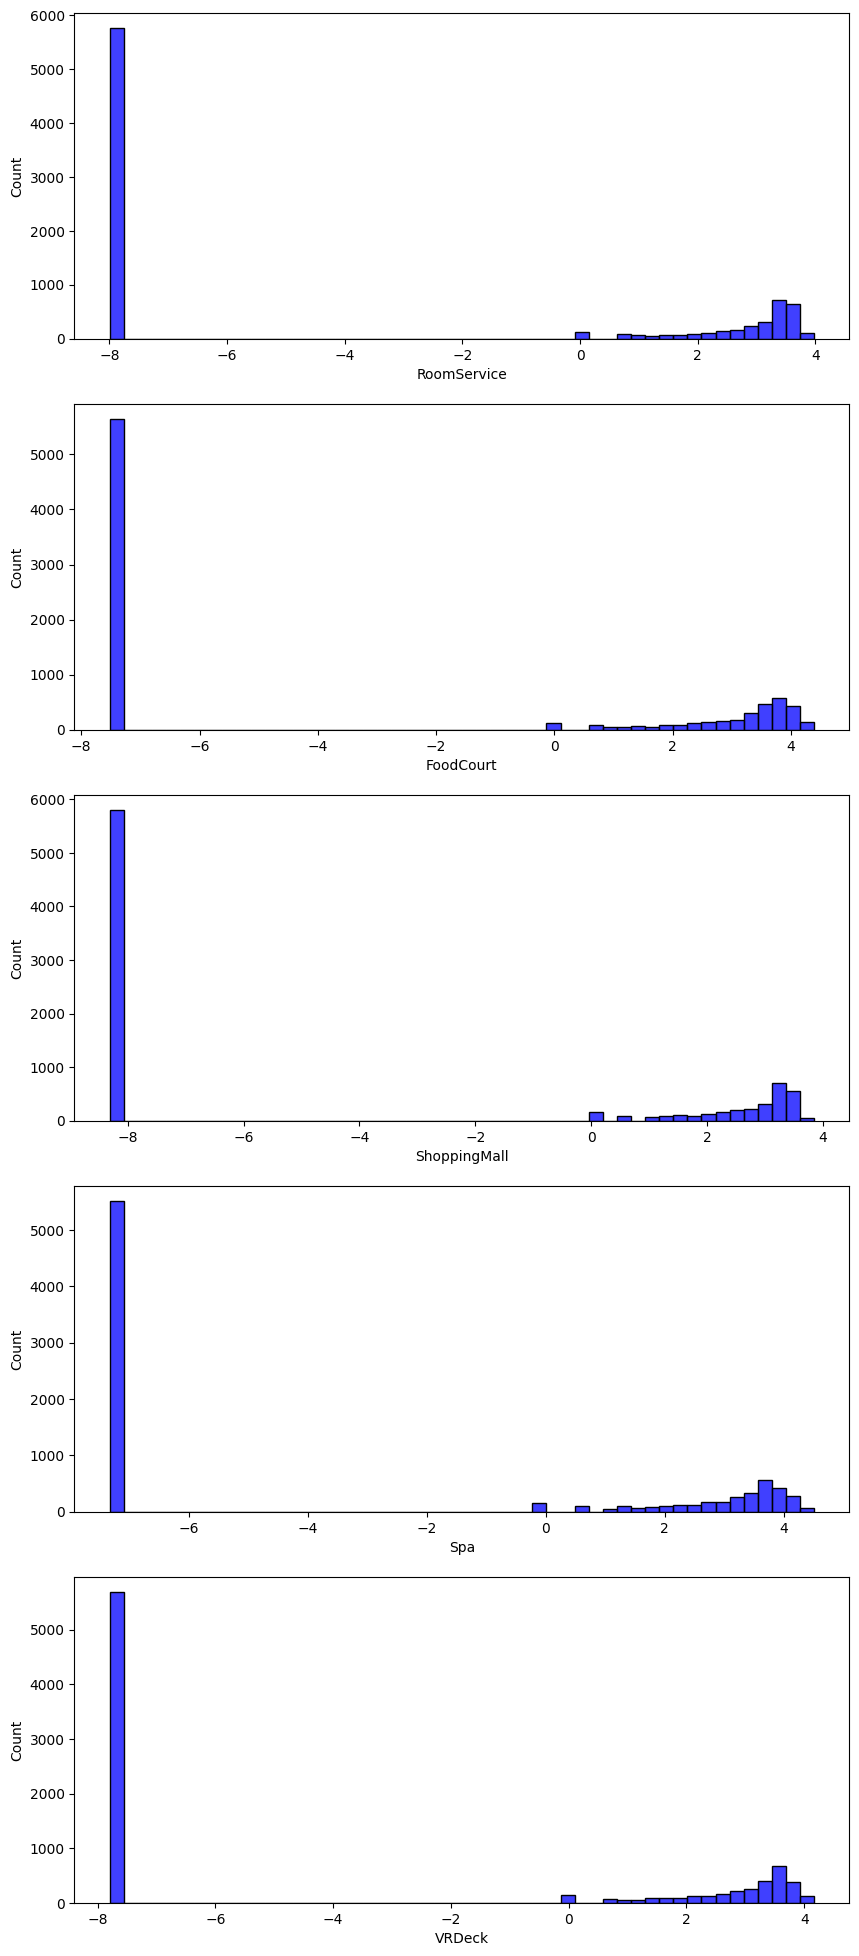

In [31]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(train_df['RoomService'], color='b', bins=50, ax=ax[0]);
sns.histplot(train_df['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(train_df['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(train_df['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(train_df['VRDeck'], color='b', bins=50, ax=ax[4]);

Looking at the scale of the features, the continious columns are all on different scales. It could be beneficial to use min-max scaling on them.

In [32]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_num,Cabin_unknown,Age_unknown,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_P,Side_S,Side_Unknown
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.790291,-4.337191,-3.797910,-4.664918,-3.543681,-4.104842,0.503624,586.624065,0.022892,0.020591,...,0.085931,0.054987,0.100771,0.321408,0.294375,0.000575,0.022892,0.483838,0.493270,0.022892
std,14.341404,5.157880,5.098626,5.187403,5.019126,5.106992,0.500016,513.880084,0.149568,0.142020,...,0.280279,0.227968,0.301042,0.467044,0.455787,0.023977,0.149568,0.499767,0.499983,0.149568
min,0.000000,-7.997523,-7.520552,-8.311794,-7.325517,-7.794963,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,-7.997523,-7.520552,-8.311794,-7.325517,-7.794963,0.000000,152.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,-7.997523,-7.520552,-8.311794,-7.325517,-7.794963,1.000000,407.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,2.533046,2.812415,2.196292,2.797146,2.561146,1.000000,983.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,79.000000,3.977631,4.392923,3.850768,4.508551,4.168245,1.000000,1894.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Scaling

Here, minmax scaling is applied to all numerical columns in the dataset. Then, the transformed columns are added to the dataset and the old columns are dropped.

In [33]:
scaler=MinMaxScaler()

scaler_train=scaler.fit_transform(train_df[continious_cols])
scaler_test=scaler.transform(test_df[continious_cols])

new_col_names=[str+'_transformed' for str in scaler.get_feature_names_out()]

scaler_train=pd.DataFrame(scaler_train, index=train_df.index, columns=new_col_names)
scaler_test=pd.DataFrame(scaler_test, index=test_df.index, columns=new_col_names)

train_df=pd.concat([train_df, scaler_train], axis=1)
test_df=pd.concat([test_df, scaler_test], axis=1)

train_df.drop(columns=continious_cols, inplace=True)
test_df.drop(columns=continious_cols, inplace=True)

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Transported                8693 non-null   float64
 1   Cabin_unknown              8693 non-null   float64
 2   Age_unknown                8693 non-null   float64
 3   HomePlanet_Earth           8693 non-null   float64
 4   HomePlanet_Europa          8693 non-null   float64
 5   HomePlanet_Mars            8693 non-null   float64
 6   HomePlanet_Unknown         8693 non-null   float64
 7   CryoSleep_False            8693 non-null   float64
 8   CryoSleep_True             8693 non-null   float64
 9   CryoSleep_Unknown          8693 non-null   float64
 10  Destination_55 Cancri e    8693 non-null   float64
 11  Destination_PSO J318.5-22  8693 non-null   float64
 12  Destination_TRAPPIST-1e    8693 non-null   float64
 13  Destination_Unknown        8693 non-null   float

In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                4277 non-null   object 
 1   Cabin_unknown              4277 non-null   float64
 2   Age_unknown                4277 non-null   float64
 3   HomePlanet_Earth           4277 non-null   float64
 4   HomePlanet_Europa          4277 non-null   float64
 5   HomePlanet_Mars            4277 non-null   float64
 6   HomePlanet_Unknown         4277 non-null   float64
 7   CryoSleep_False            4277 non-null   float64
 8   CryoSleep_True             4277 non-null   float64
 9   CryoSleep_Unknown          4277 non-null   float64
 10  Destination_55 Cancri e    4277 non-null   float64
 11  Destination_PSO J318.5-22  4277 non-null   float64
 12  Destination_TRAPPIST-1e    4277 non-null   float64
 13  Destination_Unknown        4277 non-null   float

In [36]:
print("Train data MAX value: ", train_df.max().max())
print("Train data MIN value: ", train_df.min().min())
print('-'*20)
print("Test data MAX value: ", test_df[test_df.columns[1:]].max().max())
print("Test data MIN value: ", test_df[test_df.columns[1:]].min().min())

Train data MAX value:  1.0000000000000002
Train data MIN value:  0.0
--------------------
Test data MAX value:  1.0
Test data MIN value:  0.0


Now, the data is ready to be used in artificial neural networks. 

Saving the transformed data.

In [37]:
train_df.to_csv('data/train_transformed.csv')
test_df.to_csv('data/test_transformed.csv')

The two classes in the dataset are balanced, which is convenient.

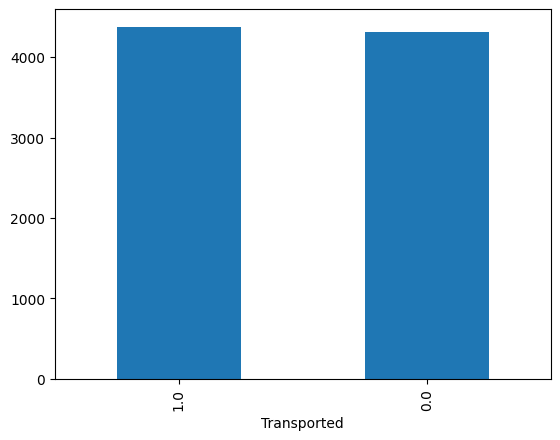

In [39]:
train_df.Transported.value_counts().plot(kind="bar");

# Artificial neural network models

## Preparation

First, splitting the train data into X and y. 

In [40]:
y=train_df['Transported'].to_numpy()
X=train_df.drop(columns='Transported').to_numpy()
X.shape

(8693, 35)

In [41]:
y.shape

(8693,)

Saving the indices of the 5 K-Fold splits for model selection.

In [42]:
train_indices = {}
validation_indices = {}
SKF = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
for i, (train_index, validation_index) in enumerate(SKF.split(X, y)):
    print(f"Fold {i}:")
    print(f"       Train: index={train_index}")
    print(f"  Validation: index={validation_index}")
    train_indices[i+1]=train_index
    validation_indices[i+1]=validation_index

Fold 0:
       Train: index=[   0    1    2 ... 8690 8691 8692]
  Validation: index=[   5   14   15 ... 8671 8676 8679]
Fold 1:
       Train: index=[   0    2    3 ... 8689 8691 8692]
  Validation: index=[   1    7    8 ... 8684 8688 8690]
Fold 2:
       Train: index=[   1    2    4 ... 8690 8691 8692]
  Validation: index=[   0    3    6 ... 8667 8669 8677]
Fold 3:
       Train: index=[   0    1    2 ... 8690 8691 8692]
  Validation: index=[  18   20   24 ... 8681 8682 8685]
Fold 4:
       Train: index=[   0    1    3 ... 8685 8688 8690]
  Validation: index=[   2    4    9 ... 8689 8691 8692]


In this project, all networks have one input layer for the 35 features and the output layer consisting of 1 neuron with sigmoid activation for binary classification.

Four different types of networks are created:
1. `Shallow`: 2 hidden layers
2. `Deeper`: 3 hidden layers
3. `Batchnorm`: 4 hidden layers with batch normalization layers after the first 3.
4. `Dropout`: 4 hidden layers with dropout after the first 2.

These models are created with different hidden layer sizes and activation functions using the functions below.

In [53]:
def create_shallow_model(activation, hidden_dim):
    inputs = Input(shape=(35,))
    layer1 = Dense(hidden_dim, activation=activation)(inputs)
    layer2 = Dense(int(hidden_dim/3), activation=activation)(layer1)
    outputs = Dense(1, activation='sigmoid')(layer2)
    return Model(inputs, outputs)

def create_deeper_model(activation, hidden_dim):
    inputs = Input(shape=(35,))
    layer1 = Dense(hidden_dim, activation=activation)(inputs)
    layer2 = Dense(int(2*hidden_dim/3), activation=activation)(layer1)
    layer3 = Dense(int(hidden_dim/3), activation=activation)(layer2)
    outputs = Dense(1, activation='sigmoid')(layer3)
    return keras.Model(inputs, outputs)

def create_batchnorm_model(activation, hidden_dim):
    inputs = Input(shape=(35,))
    layer1 = Dense(hidden_dim, activation=activation)(inputs)
    bnorm1 = BatchNormalization()(layer1)
    layer2 = Dense(int(3*hidden_dim/4), activation=activation)(bnorm1)
    bnorm2 = BatchNormalization()(layer2)
    layer3 = Dense(int(hidden_dim/2), activation=activation)(bnorm2)
    bnorm3 = BatchNormalization()(layer3)
    layer4 = Dense(int(hidden_dim/4), activation=activation)(bnorm3)
    outputs = Dense(1, activation='sigmoid')(layer4)
    return keras.Model(inputs, outputs)

def create_dropout_model(activation, hidden_dim, drop_rate, drop_seed=123):
    inputs = Input(shape=(35,))
    layer1 = Dense(hidden_dim, activation=activation)(inputs)
    drop1 = Dropout(rate=drop_rate, seed=drop_seed)(layer1)
    layer2 = Dense(int(3*hidden_dim/4), activation=activation)(drop1)
    drop2 = Dropout(rate=drop_rate, seed=drop_seed)(layer2)
    layer3 = Dense(int(hidden_dim/2), activation=activation)(layer2)
    layer4 = Dense(int(hidden_dim/4), activation=activation)(layer3)
    outputs = Dense(1, activation='sigmoid')(layer4)
    return keras.Model(inputs, outputs)

Creating some folders.

In [43]:
try:
    os.mkdir('model_weights')
except FileExistsError:
    pass
try:
    os.mkdir('model_scores')
except FileExistsError:
    pass
try:
    os.mkdir('predictions')
except FileExistsError:
    pass

## Searches for best models

### Shallow model search

Here, best hyperparameters for shallow models are searched for using 50 optuna trials. In each trial, a learning rate, optimizer, hidden layer size, hidden layer activation function and batch size are chosen. Then, five models with these hyperparameters are trained for 50 epochs on each K-fold. After every epoch, model performance is checked on the validation sets. The weights of the models with the best accuracy on validation sets are stored in separate files. The accuracies on the validation sets achieved with those weights are stored in a separate Pandas Dataframe. The optimizer tries to maximize the average validation accuracy among the 5 K-folds.

Note: this cell can take multiple hours to run.

In [98]:
n_trials=50
shallow_model_scores=pd.DataFrame(np.zeros(shape=(n_trials, 5)), 
                                  columns=[f'Fold{i}' for i in range(1,6)])

def shallow_model_trial(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.000001, 0.01, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 45, 210, step=3)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "sigmoid"])
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop", "Adagrad"])
    batch_size = trial.suggest_int("batch_size", 8, 80, step=8)

    model = create_shallow_model(activation=activation, hidden_dim=hidden_dim)

    if optimizer=='SGD':
        optmzr = SGD(learning_rate=learning_rate)
    elif optimizer=='RMSprop':
        optmzr = RMSprop(learning_rate=learning_rate)
    elif optimizer=='Adagrad':
        optmzr = Adagrad(learning_rate=learning_rate)
    else:
        optmzr = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optmzr,
                  metrics=['accuracy'])
    
    model.save_weights('model_weights/initial.h5')

    for fold_number in range(1,6):
        model.load_weights('model_weights/initial.h5')
        checkpoint = ModelCheckpoint(filepath=f'model_weights/shallow_trial{trial.number}_fold{fold_number}.h5', 
                                     save_weights_only=True, 
                                     monitor='val_accuracy', 
                                     mode='max', 
                                     save_best_only=True)
        hist = model.fit(X[train_indices[fold_number], :], y[train_indices[fold_number]], 
                         validation_data=(X[validation_indices[fold_number], :], y[validation_indices[fold_number]]), 
                         epochs=50, 
                         batch_size=batch_size, 
                         shuffle=True, verbose=0, 
                         callbacks=[checkpoint])
        shallow_model_scores.at[trial.number, f'Fold{fold_number}'] = max(hist.history['val_accuracy'])

    os.remove('model_weights/initial.h5')

    return shallow_model_scores.loc[trial.number, :].mean()


study = optuna.create_study(direction="maximize")
study.optimize(shallow_model_trial, n_trials=n_trials, show_progress_bar=True)

[I 2024-05-31 13:15:18,933] A new study created in memory with name: no-name-1a024c83-5f69-43ae-a449-88130dc64399


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-31 13:16:09,537] Trial 0 finished with value: 0.5800055146217347 and parameters: {'learning_rate': 7.041381853688856e-06, 'hidden_dim': 72, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'batch_size': 72}. Best is trial 0 with value: 0.5800055146217347.
[I 2024-05-31 13:17:04,583] Trial 1 finished with value: 0.5097206115722657 and parameters: {'learning_rate': 0.00015138347301837788, 'hidden_dim': 150, 'activation': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 64}. Best is trial 0 with value: 0.5800055146217347.
[I 2024-05-31 13:22:47,647] Trial 2 finished with value: 0.7599220633506775 and parameters: {'learning_rate': 0.0017231168147321704, 'hidden_dim': 159, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'batch_size': 8}. Best is trial 2 with value: 0.7599220633506775.
[I 2024-05-31 13:23:58,945] Trial 3 finished with value: 0.7644091367721557 and parameters: {'learning_rate': 0.00025787426613426323, 'hidden_dim': 123, 'activation': 'relu', 'optimizer': 'Adam', 'batch_

Here's how the best validation accuracies look after the cell is done running.

In [99]:
shallow_model_scores

,Fold1,Fold2,Fold3,Fold4,Fold5
0,0.584244,0.577343,0.590569,0.569620,0.578251
1,0.510063,0.509488,0.508338,0.510357,0.510357
2,0.765382,0.762507,0.749281,0.772727,0.749712
3,0.769408,0.760207,0.755032,0.777330,0.760069
4,0.775733,0.759632,0.757907,0.775029,0.769275
5,0.741806,0.727430,0.728005,0.747986,0.738205
6,0.776308,0.759632,0.763082,0.775604,0.771577
7,0.772283,0.761357,0.759057,0.771001,0.767549
8,0.635998,0.607246,0.649799,0.653049,0.621404
9,0.769983,0.757332,0.748131,0.770426,0.755466


Saving these results in a separate file.

In [102]:
shallow_model_scores.to_csv('model_scores/shallow_model_scores.csv')

Here, model hyperparameters should have also been saved, but I forgot to do that before killing the kernel. The hyperparameters were extracted separately using the output of the hyperparameter search cell.

### Deeper model search

Here, best hyperparameters for deeper models are searched for using 50 optuna trials. In each trial, a learning rate, optimizer, hidden layer size, hidden layer activation function and batch size are chosen. Then, five models with these hyperparameters are trained for 50 epochs on each K-fold. After every epoch, model performance is checked on the validation sets. The weights of the models with the best accuracy on validation sets are stored in separate files. The accuracies on the validation sets achieved with those weights are stored in a separate Pandas Dataframe. The optimizer tries to maximize the average validation accuracy among the 5 K-folds.

Note: this cell can take multiple hours to run.

In [44]:
n_trials=50
deeper_model_scores=pd.DataFrame(np.zeros(shape=(n_trials, 5)), 
                                  columns=[f'Fold{i}' for i in range(1,6)])

def deeper_model_trial(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.000001, 0.01, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 45, 240, step=3)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "sigmoid"])
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop", "Adagrad"])
    batch_size = trial.suggest_int("batch_size", 8, 80, step=8)

    model = create_deeper_model(activation=activation, hidden_dim=hidden_dim)

    if optimizer=='SGD':
        optmzr = SGD(learning_rate=learning_rate)
    elif optimizer=='RMSprop':
        optmzr = RMSprop(learning_rate=learning_rate)
    elif optimizer=='Adagrad':
        optmzr = Adagrad(learning_rate=learning_rate)
    else:
        optmzr = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optmzr,
                  metrics=['accuracy'])
    
    model.save_weights('model_weights/initial.h5')

    for fold_number in range(1,6):
        model.load_weights('model_weights/initial.h5')
        checkpoint = ModelCheckpoint(filepath=f'model_weights/deeper_trial{trial.number}_fold{fold_number}.h5', 
                                     save_weights_only=True, 
                                     monitor='val_accuracy', 
                                     mode='max', 
                                     save_best_only=True)
        hist = model.fit(X[train_indices[fold_number], :], y[train_indices[fold_number]], 
                         validation_data=(X[validation_indices[fold_number], :], y[validation_indices[fold_number]]), 
                         epochs=50, 
                         batch_size=batch_size, 
                         shuffle=True, verbose=0, 
                         callbacks=[checkpoint])
        deeper_model_scores.at[trial.number, f'Fold{fold_number}'] = max(hist.history['val_accuracy'])

    os.remove('model_weights/initial.h5')

    return deeper_model_scores.loc[trial.number, :].mean()


study = optuna.create_study(direction="maximize")
study.optimize(deeper_model_trial, n_trials=n_trials, show_progress_bar=True)

[I 2024-05-31 20:34:02,771] A new study created in memory with name: no-name-88d4e8bd-7fc5-4485-bee2-ac0e1346f1d5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-31 20:36:26,363] Trial 0 finished with value: 0.6204986691474914 and parameters: {'learning_rate': 3.14310317171781e-05, 'hidden_dim': 81, 'activation': 'relu', 'optimizer': 'SGD', 'batch_size': 24}. Best is trial 0 with value: 0.6204986691474914.
[I 2024-05-31 20:37:30,939] Trial 1 finished with value: 0.7554354786872863 and parameters: {'learning_rate': 0.0019426197128611022, 'hidden_dim': 210, 'activation': 'relu', 'optimizer': 'Adagrad', 'batch_size': 72}. Best is trial 1 with value: 0.7554354786872863.
[I 2024-05-31 20:38:21,355] Trial 2 finished with value: 0.7347301602363586 and parameters: {'learning_rate': 3.967667588534964e-06, 'hidden_dim': 108, 'activation': 'relu', 'optimizer': 'RMSprop', 'batch_size': 80}. Best is trial 1 with value: 0.7554354786872863.
[I 2024-05-31 20:39:28,828] Trial 3 finished with value: 0.48004130721092225 and parameters: {'learning_rate': 2.635517486087582e-05, 'hidden_dim': 90, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'batch_size

In [47]:
deeper_model_scores

,Fold1,Fold2,Fold3,Fold4,Fold5
0,0.640598,0.612996,0.612996,0.613349,0.622555
1,0.763657,0.754457,0.747556,0.765823,0.745685
2,0.734330,0.733180,0.727430,0.748562,0.730150
3,0.481886,0.481886,0.477286,0.480437,0.478711
4,0.717079,0.692352,0.696377,0.707710,0.708285
5,0.652099,0.615296,0.628522,0.628884,0.639816
6,0.766532,0.763657,0.749856,0.775029,0.751438
7,0.671650,0.682001,0.659574,0.683544,0.669160
8,0.756182,0.747556,0.740656,0.753740,0.745685
9,0.742381,0.732030,0.731455,0.746260,0.733026


Saving the validation scores and the hyperparameters in separate files.

In [52]:
deeper_model_scores.to_csv('model_scores/deeper_model_scores.csv')

In [63]:
pd.DataFrame({el.number : el.params for el in study.get_trials()}).T.to_csv('model_scores/deeper_model_params.csv')

### Batchnorm model search

Here, best hyperparameters for batchnorm models are searched for using 50 optuna trials. In each trial, a learning rate, optimizer, hidden layer size, hidden layer activation function and batch size are chosen. Then, five models with these hyperparameters are trained for 70 epochs on each K-fold. After every epoch, model performance is checked on the validation sets. The weights of the models with the best accuracy on validation sets are stored in separate files. The accuracies on the validation sets achieved with those weights are stored in a separate Pandas Dataframe. The optimizer tries to maximize the average validation accuracy among the 5 K-folds.

Note: this cell can take multiple hours to run.

In [64]:
n_trials=50
batchnorm_model_scores=pd.DataFrame(np.zeros(shape=(n_trials, 5)), 
                                  columns=[f'Fold{i}' for i in range(1,6)])

def batchnorm_model_trial(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.000001, 0.01, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 100, 320, step=4)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "sigmoid"])
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop", "Adagrad"])
    batch_size = trial.suggest_int("batch_size", 8, 64, step=8)

    model = create_batchnorm_model(activation=activation, hidden_dim=hidden_dim)

    if optimizer=='SGD':
        optmzr = SGD(learning_rate=learning_rate)
    elif optimizer=='RMSprop':
        optmzr = RMSprop(learning_rate=learning_rate)
    elif optimizer=='Adagrad':
        optmzr = Adagrad(learning_rate=learning_rate)
    else:
        optmzr = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optmzr,
                  metrics=['accuracy'])
    
    model.save_weights('model_weights/initial.h5')

    for fold_number in range(1,6):
        model.load_weights('model_weights/initial.h5')
        checkpoint = ModelCheckpoint(filepath=f'model_weights/batchnorm_trial{trial.number}_fold{fold_number}.h5', 
                                     save_weights_only=True, 
                                     monitor='val_accuracy', 
                                     mode='max', 
                                     save_best_only=True)
        hist = model.fit(X[train_indices[fold_number], :], y[train_indices[fold_number]], 
                         validation_data=(X[validation_indices[fold_number], :], y[validation_indices[fold_number]]), 
                         epochs=70, 
                         batch_size=batch_size, 
                         shuffle=True, verbose=0, 
                         callbacks=[checkpoint])
        batchnorm_model_scores.at[trial.number, f'Fold{fold_number}'] = max(hist.history['val_accuracy'])

    os.remove('model_weights/initial.h5')

    return batchnorm_model_scores.loc[trial.number, :].mean()


study = optuna.create_study(direction="maximize")
study.optimize(batchnorm_model_trial, n_trials=n_trials, show_progress_bar=True)

[I 2024-06-01 09:10:11,856] A new study created in memory with name: no-name-e1921ac3-d41c-4011-b048-5e782a693c2f


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-01 09:14:18,835] Trial 0 finished with value: 0.7603827714920044 and parameters: {'learning_rate': 0.00024079352222961082, 'hidden_dim': 124, 'activation': 'relu', 'optimizer': 'RMSprop', 'batch_size': 24}. Best is trial 0 with value: 0.7603827714920044.
[I 2024-06-01 09:16:45,365] Trial 1 finished with value: 0.7665946960449219 and parameters: {'learning_rate': 0.0007069954257200263, 'hidden_dim': 200, 'activation': 'sigmoid', 'optimizer': 'RMSprop', 'batch_size': 56}. Best is trial 1 with value: 0.7665946960449219.
[I 2024-06-01 09:18:41,723] Trial 2 finished with value: 0.7724610447883606 and parameters: {'learning_rate': 0.005217404651361862, 'hidden_dim': 152, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'batch_size': 64}. Best is trial 2 with value: 0.7724610447883606.
[I 2024-06-01 09:20:59,555] Trial 3 finished with value: 0.7492233633995056 and parameters: {'learning_rate': 0.00020273754236319776, 'hidden_dim': 196, 'activation': 'leaky_relu', 'optimizer': 'A

Saving the validation scores and the hyperparameters in separate files.

In [66]:
batchnorm_model_scores.to_csv('model_scores/batchnorm_model_scores.csv')

In [68]:
pd.DataFrame({el.number : el.params for el in study.get_trials()}).T.to_csv('model_scores/batchnorm_model_params.csv')

### Dropout model search

Here, best hyperparameters for dropout models are searched for using 50 optuna trials. In each trial, a learning rate, optimizer, hidden layer size, hidden layer activation function, dropout rate and batch size are chosen. Then, five models with these hyperparameters are trained for 70 epochs on each K-fold. After every epoch, model performance is checked on the validation sets. The weights of the models with the best accuracy on validation sets are stored in separate files. The accuracies on the validation sets achieved with those weights are stored in a separate Pandas Dataframe. The optimizer tries to maximize the average validation accuracy among the 5 K-folds.

Note: this cell can take multiple hours to run.

In [71]:
n_trials=50
dropout_model_scores=pd.DataFrame(np.zeros(shape=(n_trials, 5)), 
                                  columns=[f'Fold{i}' for i in range(1,6)])

def dropout_model_trial(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.000001, 0.01, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 120, 360, step=4)
    drop_rate = trial.suggest_float("drop_rate", 0.1, 0.5, step=0.05)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "sigmoid"])
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop", "Adagrad"])
    batch_size = trial.suggest_int("batch_size", 8, 64, step=8)

    model = create_dropout_model(activation=activation, hidden_dim=hidden_dim, drop_rate=drop_rate)

    if optimizer=='SGD':
        optmzr = SGD(learning_rate=learning_rate)
    elif optimizer=='RMSprop':
        optmzr = RMSprop(learning_rate=learning_rate)
    elif optimizer=='Adagrad':
        optmzr = Adagrad(learning_rate=learning_rate)
    else:
        optmzr = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optmzr,
                  metrics=['accuracy'])
    
    model.save_weights('model_weights/initial.h5')

    for fold_number in range(1,6):
        model.load_weights('model_weights/initial.h5')
        checkpoint = ModelCheckpoint(filepath=f'model_weights/dropout_trial{trial.number}_fold{fold_number}.h5', 
                                     save_weights_only=True, 
                                     monitor='val_accuracy', 
                                     mode='max', 
                                     save_best_only=True)
        hist = model.fit(X[train_indices[fold_number], :], y[train_indices[fold_number]], 
                         validation_data=(X[validation_indices[fold_number], :], y[validation_indices[fold_number]]), 
                         epochs=70, 
                         batch_size=batch_size, 
                         shuffle=True, verbose=0, 
                         callbacks=[checkpoint])
        dropout_model_scores.at[trial.number, f'Fold{fold_number}'] = max(hist.history['val_accuracy'])

    os.remove('model_weights/initial.h5')

    return dropout_model_scores.loc[trial.number, :].mean()


study = optuna.create_study(direction="maximize")
study.optimize(dropout_model_trial, n_trials=n_trials, show_progress_bar=True)

[I 2024-06-01 12:43:10,043] A new study created in memory with name: no-name-053ccf55-2846-4e10-83a2-68670689573b


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-01 12:46:16,831] Trial 0 finished with value: 0.7596921324729919 and parameters: {'learning_rate': 0.004587767594176943, 'hidden_dim': 172, 'drop_rate': 0.45000000000000007, 'activation': 'leaky_relu', 'optimizer': 'Adagrad', 'batch_size': 32}. Best is trial 0 with value: 0.7596921324729919.
[I 2024-06-01 12:53:08,213] Trial 1 finished with value: 0.750374436378479 and parameters: {'learning_rate': 6.06897781504284e-05, 'hidden_dim': 284, 'drop_rate': 0.35, 'activation': 'sigmoid', 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.7596921324729919.
[I 2024-06-01 12:55:11,238] Trial 2 finished with value: 0.7435877442359924 and parameters: {'learning_rate': 3.936183087793012e-05, 'hidden_dim': 132, 'drop_rate': 0.1, 'activation': 'sigmoid', 'optimizer': 'Adam', 'batch_size': 56}. Best is trial 0 with value: 0.7596921324729919.
[I 2024-06-01 12:57:46,455] Trial 3 finished with value: 0.49637643694877626 and parameters: {'learning_rate': 2.494699587028014e-0

Saving the validation scores and the hyperparameters in separate files.

In [73]:
dropout_model_scores.to_csv('model_scores/dropout_model_scores.csv')

In [79]:
pd.DataFrame({el.number : el.params for el in study.get_trials()}).T.to_csv('model_scores/dropout_model_params.csv')

## Predictions on the test set

Preparing the test dataset for predictions

In [44]:
test=test_df.drop(columns='PassengerId').to_numpy()
test.shape

(4277, 35)

In this section, for each of the 4 model types the following types of predictions are calculated:
1. `Best single model`: using 1 model with the best validation accuracy.
2. `Hard voting`: using the 5 models with the same hyperparameters that have the highest average validation accuracy for hard voting.
3. `Soft voting`: using the 5 models with the same hyperparameters that have the highest average validation accuracy for soft voting. 

### Shallow models

Loading the shallow model scores and parameters.

In [45]:
shallow_scores=pd.read_csv('model_scores/shallow_model_scores.csv', index_col=0)
shallow_params=pd.read_csv('model_scores/shallow_model_params.csv', index_col=0)

#### Best single model

Seeing the best validation score for each fold and the number of trial associated with it.

In [49]:
pd.concat([shallow_scores.idxmax(), shallow_scores.max()], axis=1)

,0,1
Fold1,31,0.780909
Fold2,41,0.766532
Fold3,32,0.764807
Fold4,43,0.782509
Fold5,22,0.775604


The best score was achieved for fold 4 on trial 43. 

Checking the hyperparameters for trial 43.

In [50]:
shallow_params.loc[43]

learning_rate    0.004183
hidden_dim            102
activation        sigmoid
optimizer            Adam
batch_size             32
Name: 43, dtype: object

Creating a model with these hyperparameters and loading weights from the appropriate file.  

In [54]:
shallow_modle=create_shallow_model(activation='sigmoid', hidden_dim=102)
shallow_modle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.004183, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
shallow_modle.load_weights('model_weights/shallow_trial43_fold4.h5')
print('Train score: ', accuracy_score(y_true=y[train_indices[4]], 
               y_pred=(shallow_modle.predict(X[train_indices[4], :])>0.5).astype(float).reshape(-1)))
print('Validation score: ', accuracy_score(y_true=y[validation_indices[4]], 
               y_pred=(shallow_modle.predict(X[validation_indices[4], :])>0.5).astype(float).reshape(-1)))

218/218 [==============================] - 0s 1ms/step
Train score:  0.7677929547088426
55/55 [==============================] - 0s 1ms/step
Validation score:  0.7825086306098964


Creating the prediction on the test set and looking at the class distribution

In [55]:
test_pred=(shallow_modle.predict(test)>0.5).astype(float).reshape(-1)
test_pred=pd.Series(test_pred, name='Transported')
test_pred.value_counts()

134/134 [==============================] - 0s 1ms/step


Transported
0.0    2285
1.0    1992
Name: count, dtype: int64

This class distribution is more unbalanced than the one of the train set, which suggests that this model probably predicts True too few times.

Saving the prediction as a separate csv file.

In [56]:
prediction=pd.DataFrame([test_df.PassengerId, test_pred.astype(bool)]).T
prediction

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [57]:
prediction.to_csv('predictions/shallow_best_single_model.csv',index=False)

This prediction achieved the score of `0.76665` 

#### Hard voting

The best-scoring trial, i.e. the trial with the highest average validation score, was trial 22.

Checking the hyperparameters for trial 22. 

In [58]:
shallow_params.loc[22]

learning_rate      0.004172
hidden_dim               90
activation       leaky_relu
optimizer              Adam
batch_size               16
Name: 22, dtype: object

Creating a model with these hyperparameters and getting the test predictions of the 5 models fit on 5 different folds by loading their weights.  

In [59]:
test_preds={}
muddle=create_shallow_model(activation='leaky_relu', hidden_dim=90)
muddle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.004172, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
for fold_number in range(1,6):
    muddle.load_weights(f'model_weights/shallow_trial22_fold{fold_number}.h5')
    test_preds[fold_number]=(muddle.predict(test)>0.5).astype(float).reshape(-1)
test_preds=pd.DataFrame(test_preds)
test_preds

134/134 [==============================] - 0s 1ms/step


,1,2,3,4,5
0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
4272,1.0,1.0,1.0,1.0,1.0
4273,0.0,0.0,0.0,0.0,0.0
4274,1.0,1.0,1.0,1.0,1.0
4275,0.0,1.0,0.0,0.0,1.0


Creating the hard voting prediction by calculating the median value and looking at the class distribution.

In [60]:
combo_pred=test_preds.median(axis=1)
combo_pred.name='Transported'
combo_pred.value_counts()

Transported
0.0    2326
1.0    1951
Name: count, dtype: int64

This distribution of this prediction is more unbalanced than the distribution of the "best single model" prediction.

Saving the prediction as a separate csv file.

In [61]:
prediction_combo=pd.DataFrame([test_df.PassengerId, combo_pred.astype(bool)]).T
prediction_combo

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [62]:
prediction_combo.to_csv('predictions/shallow_combo.csv',index=False)

This prediction achieved the score of `0.76736` 

#### Soft voting

For soft voting, the actual model output is extracted from the same models

In [63]:
test_preds={}
muddle=create_shallow_model(activation='leaky_relu', hidden_dim=90)
muddle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.004172, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
for fold_number in range(1,6):
    muddle.load_weights(f'model_weights/shallow_trial22_fold{fold_number}.h5')
    test_preds[fold_number]=(muddle.predict(test)).reshape(-1)
test_preds=pd.DataFrame(test_preds)
test_preds

134/134 [==============================] - 0s 1ms/step


,1,2,3,4,5
0,0.465036,0.630955,0.479872,0.651908,0.415402
1,0.180262,0.298111,0.090292,0.328308,0.015027
2,0.999755,0.998551,0.999998,0.998452,0.999989
3,0.614001,0.523583,0.571356,0.528540,0.566190
4,0.215698,0.301513,0.337676,0.388507,0.164882
...,...,...,...,...,...
4272,0.883107,0.795236,0.835899,0.816177,0.778831
4273,0.450122,0.305516,0.300116,0.270281,0.203342
4274,0.995152,0.971168,0.997316,0.933874,0.997133
4275,0.240986,0.675797,0.026259,0.227561,0.889799


Creating the hard voting prediction by calculating the sum and comparing it with 2.5, which is half of the number of models.

In [64]:
sum_pred=(test_preds.sum(axis=1)>2.5)
sum_pred.name='Transported'
sum_pred.value_counts()

Transported
False    2296
True     1981
Name: count, dtype: int64

For soft voting, the class distribution is more balanced than for hard voting.

Saving the prediction as a separate csv file.

In [65]:
prediction_sum=pd.DataFrame([test_df.PassengerId, sum_pred]).T
prediction_sum

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [66]:
prediction_sum.to_csv('predictions/shallow_sum.csv',index=False)

This prediction achieved the score of `0.77063` 

Same things were done for the other types of models.

### Deeper models

In [67]:
deeper_scores=pd.read_csv('model_scores/deeper_model_scores.csv', index_col=0)
deeper_params=pd.read_csv('model_scores/deeper_model_params.csv', index_col=0)

#### Best single model

In [68]:
pd.concat([deeper_scores.idxmax(), deeper_scores.max()], axis=1)

,0,1
Fold1,32,0.781484
Fold2,14,0.765382
Fold3,32,0.762507
Fold4,45,0.780207
Fold5,41,0.773878


In [69]:
deeper_params.loc[32]

learning_rate      0.002435
hidden_dim              162
activation       leaky_relu
optimizer              Adam
batch_size                8
Name: 32, dtype: object

In [86]:
deeper_modle=create_deeper_model(activation='leaky_relu', hidden_dim=162)
deeper_modle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.002435, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
deeper_modle.load_weights('model_weights/deeper_trial32_fold1.h5')
print('Train score: ', accuracy_score(y_true=y[train_indices[1]], 
               y_pred=(deeper_modle.predict(X[train_indices[1], :])>0.5).astype(float).reshape(-1)))
print('Validation score: ', accuracy_score(y_true=y[validation_indices[1]], 
               y_pred=(deeper_modle.predict(X[validation_indices[1], :])>0.5).astype(float).reshape(-1)))

218/218 [==============================] - 0s 1ms/step
Train score:  0.810468794938165
55/55 [==============================] - 0s 1ms/step
Validation score:  0.7814836112708453


In [87]:
test_pred=(deeper_modle.predict(test)>0.5).astype(float).reshape(-1)
test_pred=pd.Series(test_pred, name='Transported')
test_pred.value_counts()

134/134 [==============================] - 0s 1ms/step


Transported
0.0    2190
1.0    2087
Name: count, dtype: int64

In [88]:
prediction=pd.DataFrame([test_df.PassengerId, test_pred.astype(bool)]).T
prediction.to_csv('predictions/deeper_best_single_model.csv',index=False)

This prediction achieved the score of `0.76923` 

#### Hard voting

In [73]:
deeper_params.loc[32]

learning_rate      0.002435
hidden_dim              162
activation       leaky_relu
optimizer              Adam
batch_size                8
Name: 32, dtype: object

In [74]:
test_preds={}
muddle=create_deeper_model(activation='leaky_relu', hidden_dim=162)
muddle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.002435, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
for fold_number in range(1,6):
    muddle.load_weights(f'model_weights/deeper_trial32_fold{fold_number}.h5')
    test_preds[fold_number]=(muddle.predict(test)>0.5).astype(float).reshape(-1)
test_preds=pd.DataFrame(test_preds)

combo_pred=test_preds.median(axis=1)
combo_pred.name='Transported'
combo_pred.value_counts()

134/134 [==============================] - 0s 1ms/step


Transported
0.0    2308
1.0    1969
Name: count, dtype: int64

In [75]:
prediction_combo=pd.DataFrame([test_df.PassengerId, combo_pred.astype(bool)]).T
prediction_combo.to_csv('predictions/deeper_combo.csv',index=False)

This prediction achieved the score of `0.76876` 

#### Soft voting

In [77]:
test_preds={}
muddle=create_deeper_model(activation='leaky_relu', hidden_dim=162)
muddle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.002435, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
for fold_number in range(1,6):
    muddle.load_weights(f'model_weights/deeper_trial32_fold{fold_number}.h5')
    test_preds[fold_number]=(muddle.predict(test)).reshape(-1)
test_preds=pd.DataFrame(test_preds)

sum_pred=(test_preds.sum(axis=1)>2.5)
sum_pred.name='Transported'
sum_pred.value_counts()

134/134 [==============================] - 0s 1ms/step


Transported
False    2305
True     1972
Name: count, dtype: int64

In [78]:
prediction_sum=pd.DataFrame([test_df.PassengerId, sum_pred]).T
prediction_sum.to_csv('predictions/deeper_sum.csv',index=False)

This prediction achieved the score of `0.77180` 

### Batchnorm models

In [80]:
batchnorm_scores=pd.read_csv('model_scores/batchnorm_model_scores.csv', index_col=0)
batchnorm_params=pd.read_csv('model_scores/batchnorm_model_params.csv', index_col=0)

#### Best single model

In [81]:
pd.concat([batchnorm_scores.idxmax(), batchnorm_scores.max()], axis=1)

,0,1
Fold1,47,0.789534
Fold2,16,0.773433
Fold3,42,0.774008
Fold4,42,0.787687
Fold5,21,0.782509


In [83]:
batchnorm_params.loc[47]

learning_rate      0.006773
hidden_dim              164
activation       leaky_relu
optimizer           RMSprop
batch_size               24
Name: 47, dtype: object

In [89]:
batchnorm_modle=create_batchnorm_model(activation='leaky_relu', hidden_dim=164)
batchnorm_modle.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.006773),
              metrics=['accuracy'])
batchnorm_modle.load_weights('model_weights/batchnorm_trial47_fold1.h5')
print('Train score: ', accuracy_score(y_true=y[train_indices[1]], 
               y_pred=(batchnorm_modle.predict(X[train_indices[1], :])>0.5).astype(float).reshape(-1)))
print('Validation score: ', accuracy_score(y_true=y[validation_indices[1]], 
               y_pred=(batchnorm_modle.predict(X[validation_indices[1], :])>0.5).astype(float).reshape(-1)))

218/218 [==============================] - 0s 1ms/step
Train score:  0.819959735404084
55/55 [==============================] - 0s 2ms/step
Validation score:  0.78953421506613


In [90]:
test_pred=(batchnorm_modle.predict(test)>0.5).astype(float).reshape(-1)
test_pred=pd.Series(test_pred, name='Transported')
test_pred.value_counts()

134/134 [==============================] - 0s 2ms/step


Transported
1.0    2202
0.0    2075
Name: count, dtype: int64

In [91]:
prediction=pd.DataFrame([test_df.PassengerId, test_pred.astype(bool)]).T
prediction.to_csv('predictions/batchnorm_best_single_model.csv',index=False)

This prediction achieved the score of `0.76291` 

#### Hard voting

In [93]:
batchnorm_params.loc[16]

learning_rate      0.009557
hidden_dim              164
activation       leaky_relu
optimizer           RMSprop
batch_size               32
Name: 16, dtype: object

In [94]:
test_preds={}
muddle=create_batchnorm_model(activation='leaky_relu', hidden_dim=164)
muddle.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.009557),
              metrics=['accuracy'])
for fold_number in range(1,6):
    muddle.load_weights(f'model_weights/batchnorm_trial16_fold{fold_number}.h5')
    test_preds[fold_number]=(muddle.predict(test)>0.5).astype(float).reshape(-1)
test_preds=pd.DataFrame(test_preds)

combo_pred=test_preds.median(axis=1)
combo_pred.name='Transported'
combo_pred.value_counts()

134/134 [==============================] - 0s 2ms/step


Transported
0.0    2208
1.0    2069
Name: count, dtype: int64

In [95]:
prediction_combo=pd.DataFrame([test_df.PassengerId, combo_pred.astype(bool)]).T
prediction_combo.to_csv('predictions/batchnorm_combo.csv',index=False)

This prediction achieved the score of `0.77671` 

#### Soft voting

In [96]:
test_preds={}
muddle=create_batchnorm_model(activation='leaky_relu', hidden_dim=164)
muddle.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.009557),
              metrics=['accuracy'])
for fold_number in range(1,6):
    muddle.load_weights(f'model_weights/batchnorm_trial16_fold{fold_number}.h5')
    test_preds[fold_number]=(muddle.predict(test)).reshape(-1)
test_preds=pd.DataFrame(test_preds)
test_preds

sum_pred=(test_preds.sum(axis=1)>2.5)
sum_pred.name='Transported'
sum_pred.value_counts()

134/134 [==============================] - 0s 1ms/step


Transported
False    2216
True     2061
Name: count, dtype: int64

In [97]:
prediction_sum=pd.DataFrame([test_df.PassengerId, sum_pred]).T
prediction_sum.to_csv('predictions/batchnorm_sum.csv',index=False)

This prediction achieved the score of `0.78279` 

### Dropout models

In [98]:
dropout_scores=pd.read_csv('model_scores/dropout_model_scores.csv', index_col=0)
dropout_params=pd.read_csv('model_scores/dropout_model_params.csv', index_col=0)

#### Best single model

In [99]:
pd.concat([dropout_scores.idxmax(), dropout_scores.max()], axis=1)

,0,1
Fold1,12,0.780334
Fold2,26,0.763082
Fold3,23,0.764232
Fold4,42,0.783084
Fold5,26,0.774453


In [100]:
dropout_params.loc[42]

learning_rate      0.000248
hidden_dim              252
drop_rate              0.35
activation       leaky_relu
optimizer              Adam
batch_size               48
Name: 42, dtype: object

In [101]:
dropout_modle=create_dropout_model(activation='leaky_relu', hidden_dim=252, drop_rate=0.35)
dropout_modle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.000248, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
dropout_modle.load_weights('model_weights/dropout_trial42_fold4.h5')
print('Train score: ', accuracy_score(y_true=y[train_indices[4]], 
               y_pred=(dropout_modle.predict(X[train_indices[4], :])>0.5).astype(float).reshape(-1)))
print('Validation score: ', accuracy_score(y_true=y[validation_indices[4]], 
               y_pred=(dropout_modle.predict(X[validation_indices[4], :])>0.5).astype(float).reshape(-1)))

218/218 [==============================] - 0s 2ms/step
Train score:  0.7657800143781452
55/55 [==============================] - 0s 2ms/step
Validation score:  0.783084004602992


In [102]:
test_pred=(dropout_modle.predict(test)>0.5).astype(float).reshape(-1)
test_pred=pd.Series(test_pred, name='Transported')
test_pred.value_counts()

134/134 [==============================] - 0s 1ms/step


Transported
0.0    2261
1.0    2016
Name: count, dtype: int64

In [103]:
prediction=pd.DataFrame([test_df.PassengerId, test_pred.astype(bool)]).T
prediction.to_csv('predictions/dropout_best_single_model.csv',index=False)

This prediction achieved the score of `0.76432` 

#### Hard voting

In [104]:
dropout_params.loc[26]

learning_rate      0.000895
hidden_dim              236
drop_rate              0.25
activation       leaky_relu
optimizer              Adam
batch_size               40
Name: 26, dtype: object

In [106]:
test_preds={}
muddle=create_dropout_model(activation='leaky_relu', hidden_dim=236, drop_rate=0.25)
muddle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.000895, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
for fold_number in range(1,6):
    muddle.load_weights(f'model_weights/dropout_trial26_fold{fold_number}.h5')
    test_preds[fold_number]=(muddle.predict(test)>0.5).astype(float).reshape(-1)
test_preds=pd.DataFrame(test_preds)

combo_pred=test_preds.median(axis=1)
combo_pred.name='Transported'
combo_pred.value_counts()

134/134 [==============================] - 0s 2ms/step


Transported
0.0    2351
1.0    1926
Name: count, dtype: int64

In [107]:
prediction_combo=pd.DataFrame([test_df.PassengerId, combo_pred.astype(bool)]).T
prediction_combo.to_csv('predictions/dropout_combo.csv',index=False)

This prediction achieved the score of `0.77039` 

#### Soft voting

In [108]:
test_preds={}
muddle=create_dropout_model(activation='leaky_relu', hidden_dim=236, drop_rate=0.25)
muddle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.000895, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
for fold_number in range(1,6):
    muddle.load_weights(f'model_weights/dropout_trial26_fold{fold_number}.h5')
    test_preds[fold_number]=(muddle.predict(test)).reshape(-1)
test_preds=pd.DataFrame(test_preds)

sum_pred=(test_preds.sum(axis=1)>2.5)
sum_pred.name='Transported'
sum_pred.value_counts()

134/134 [==============================] - 0s 2ms/step


Transported
False    2310
True     1967
Name: count, dtype: int64

In [109]:
prediction_sum=pd.DataFrame([test_df.PassengerId, sum_pred]).T
prediction_sum.to_csv('predictions/dropout_sum.csv',index=False)

This prediction achieved the score of `0.77250` 

### Bonus

Since soft voting with batchnorm models had the best result, I wanted to try the same thing, but not with similar models. Instead, this prediction uses different batchnorm models, that individually had the best validation scores on the 5 folds.

In [110]:
pd.concat([batchnorm_scores.idxmax(), batchnorm_scores.max()], axis=1)

,0,1
Fold1,47,0.789534
Fold2,16,0.773433
Fold3,42,0.774008
Fold4,42,0.787687
Fold5,21,0.782509


In [111]:
batchnorm_params.loc[[16, 21, 42, 47]]

,learning_rate,hidden_dim,activation,optimizer,batch_size
16,0.009557,164,leaky_relu,RMSprop,32
21,0.005547,180,leaky_relu,Adam,48
42,0.005537,204,leaky_relu,RMSprop,32
47,0.006773,164,leaky_relu,RMSprop,24


In [115]:
test_preds={}

# fold 1
fold_number = 1
muddle=create_batchnorm_model(activation='leaky_relu', hidden_dim=164)
muddle.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.006773),
              metrics=['accuracy'])
muddle.load_weights(f'model_weights/batchnorm_trial47_fold{fold_number}.h5')
test_preds[fold_number]=(muddle.predict(test)).reshape(-1)

# fold 2
fold_number = 2
muddle=create_batchnorm_model(activation='leaky_relu', hidden_dim=164)
muddle.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.009557),
              metrics=['accuracy'])
muddle.load_weights(f'model_weights/batchnorm_trial16_fold{fold_number}.h5')
test_preds[fold_number]=(muddle.predict(test)).reshape(-1)

# fold 3
fold_number = 3
muddle=create_batchnorm_model(activation='leaky_relu', hidden_dim=204)
muddle.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.005537),
              metrics=['accuracy'])
muddle.load_weights(f'model_weights/batchnorm_trial42_fold{fold_number}.h5')
test_preds[fold_number]=(muddle.predict(test)).reshape(-1)

# fold 4
fold_number = 4
muddle=create_batchnorm_model(activation='leaky_relu', hidden_dim=204)
muddle.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.005537),
              metrics=['accuracy'])
muddle.load_weights(f'model_weights/batchnorm_trial42_fold{fold_number}.h5')
test_preds[fold_number]=(muddle.predict(test)).reshape(-1)

# fold 5
fold_number = 5
muddle=create_batchnorm_model(activation='leaky_relu', hidden_dim=180)
muddle.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.005547, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
muddle.load_weights(f'model_weights/batchnorm_trial21_fold{fold_number}.h5')
test_preds[fold_number]=(muddle.predict(test)).reshape(-1)
test_preds=pd.DataFrame(test_preds)

sum_pred=(test_preds.sum(axis=1)>2.5)
sum_pred.name='Transported'
sum_pred.value_counts()

134/134 [==============================] - 0s 2ms/step


Transported
False    2259
True     2018
Name: count, dtype: int64

In [116]:
prediction_sum=pd.DataFrame([test_df.PassengerId, sum_pred]).T
prediction_sum.to_csv('predictions/batchnorm_bonus_sum.csv',index=False)

This prediction achieved the score of `0.78115` 

# Summary and conclusions

In this project, I created 4 types of artificial neural network models (`Shallow`, `Deeper`, `Batchnorm`, `Dropout`), and searched for best hyper parameters using K-Fold cross-validation. Then, I used the saved weights and hyperparameters to sumbit 3 types of predictions (`Best single`, `Soft voting`, `Hard voting`) to the `Spaceship Titanic` contest, as well as a `Bonus` prediction for `Batchnorm` models, which effectively used soft voting with slightly different models. 

These models achieved the following accuracy scores on the test set.

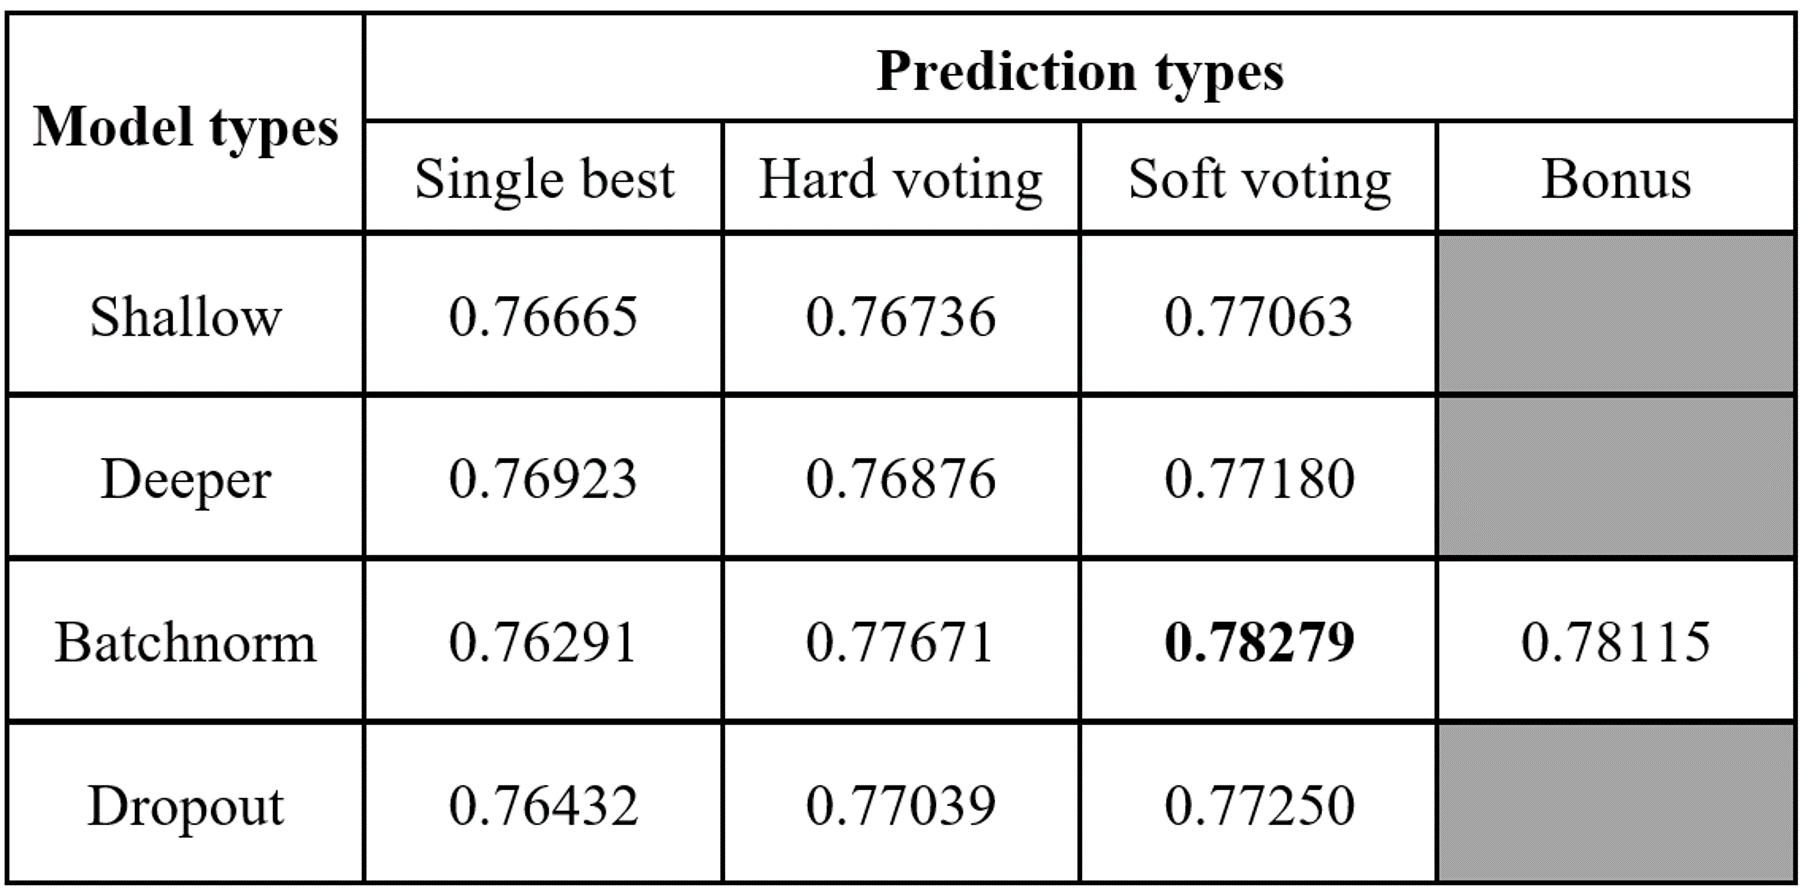

It's clear that `Batchnorm` models produced the best results, therefore, they are the recommended type of model.

Other conclusions:
1. Overall, the results achieved in this project were pretty high. They put me around the 1800th spot on the rolling leaderboard. I consider this result a success, since this is my first Kaggle competition, I completed all the coding alone in only a few days, and I was only 3% or so away from the top 100 (a lot of people seem to submit entries to this competition). 
2. From the results, it can be clearly seen that ensemble methods of hard and soft voting offer a clear advantage over using any model alone. This is not surprising, since all models in this project were trained and validated on only one of the folds. In a normal machine learning setting, these cross-validation results are generally used only for hyperparameter selection. However, fine-tuning existing neural networks or training new neural networks from scratch can be hard even with the "best" hyperparameters. I think these results show that using models from cross-validation as a part of an ensemble is a good alternative to creating new models. 
3. Also, since the cross-validated models are fit on different parts of the data, combining them can actually reduce the possibility of overfitting.
4. The vast majority of best-performing models used leaky ReLU as the activation function and either RMSProp or Adam as optimizers. Perhaps, in future hyperparameter searches it would make sense to limit the options to only those.
5. Models with 3 hidden layers offered very little improvement in comparison to models with only 2 hidden layers. This shows that in practice, adding more layers should come with more regularization like dropout or, even better, Batch normalization.

# Suggestions for future work

1. Try to perform data analysis differently: avoid adding extra columns showing where values were unknown or drop some one-hot encoded columns.
2. Try splitting input into different parts, for example, have columns `Age` and `Age_unknown` be a separate input to emphasise the relationship between those columns, which may be difficult to determine for a model when all features come together in one input.
3. Try using, not deleting, the names of the passengers. Perhaps a hashing function transforming them to numbers can be used to create one more feature.
4. Try training deeper neural networks.
5. Try using non-deep learning methods like random forests or gradient boosting and compare the results.